<sup><sub>

# 📘 CIFAKE Real vs Fake Classification  
### High-Performance Baseline with RAM Caching • cv2 • AMP • Lightweight CNN

This notebook implements a **clean, efficient, and GPU-friendly training pipeline** for detecting **AI-generated (FAKE)** vs **REAL** images in the CIFAKE dataset.  
The design focuses on removing common bottlenecks by performing all preprocessing **once** during dataset initialization and training with **mixed precision** for maximum throughput.

---

## 🚀 Overview

Image training often suffers from slow dataset loading, repeated transforms, and CPU bottlenecks.  
This notebook avoids those issues through:

- **RAM-cached dataset** (images decoded once using cv2)  
- **Preallocated tensors** for zero-copy reads during training  
- **Simplified DataLoader** tuned for RAM reads  
- **Mixed precision (AMP)** for faster GPU computation  
- **Lightweight CNN baseline** suitable for 64×64 inputs  

This results in a **stable, fast, and easy-to-understand baseline** suitable for experimentation.

---

## ⚙️ Data Pipeline (Efficient & Simple)

### **RAM-Cached Dataset**
- Images loaded once with `cv2`  
- Resized to 64×64  
- Normalized to `[0,1]`  
- Stored in a preallocated `(N, 3, 64, 64)` tensor  
- Multithreaded loading via `ThreadPoolExecutor`

This eliminates disk I/O during training and ensures consistent batch times.

### **DataLoader Settings**
- `num_workers = 0` (RAM reads are instant)  
- `pin_memory = True`  
- `batch_size = 128`  
- No Python-level transforms inside the loop  

Designed to keep the GPU fed without overhead.

---

## 🧩 Model Architecture

A compact convolutional network built for small images:

- Three convolutional blocks with BatchNorm and MaxPool  
- Fully connected classifier head  
- Outputs a single logit for binary classification  

The architecture is intentionally simple, making it easy to extend or replace.

---

## 🏋️ Training

Training uses:

- `torch.amp.autocast()` for FP16  
- `GradScaler` for numerical stability  
- Adam optimizer  
- BCEWithLogitsLoss  

The loop performs:

- Non-blocking GPU transfers  
- Accurate accuracy tracking  
- Per-epoch validation  
- Epoch timing  

The implementation is direct and easy to modify.

---

## 🖼 Sample Visualization

A small grid of images is shown to verify:

- Correct RGB loading  
- Preprocessing consistency  
- Label correctness  
- Data integrity before training  

Useful for catching dataset issues early.

---

## 📊 Dataset Summary

- **Dataset:** CIFAKE (Real vs AI-Generated)  
- **Classes:** 0 = Fake, 1 = Real  
- **Image Size:** 64×64 after preprocessing  
- **Balanced:** Roughly equal class distribution  

---

## 🔧 Future Enhancements

Potential improvements beyond this baseline:

- Data augmentation  
- MobileNet / EfficientNet backbones  
- Best-model checkpointing  
- ROC-AUC, F1 metrics  
- `torch.compile` for further speed  
- Export to ONNX or TensorRT  
- Interactive inference UI (Streamlit/Gradio)  

---

## 🎯 Summary

This notebook provides a **clear, efficient baseline** for CIFAKE classification with:

- Fast preprocessing  
- Stable training  
- Clean modular components  
- High GPU utilization  

It is designed for users who want a **reliable starting point** that is easy to extend and experiment with.

If this notebook helps:  
⭐ Upvote • 🔁 Fork • 💬 Feedback

</sub></sup>

In [1]:
import os
import cv2
import torch
import time
import matplotlib.pyplot as plt
from torchvision import transforms
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

<sup><sub>

## 📦 Dataset & DataLoader

### 🧠 Custom Dataset (RAM-Cached)

The custom `Dataset` class:

- Reads all image paths from a directory  
- Uses `ThreadPoolExecutor` to load images in parallel  
- For each image:  
  - `cv2.imread` → `cv2.cvtColor` (BGR → RGB)  
  - Resize to 64×64  
  - Convert to tensor `(C, H, W)`  
  - Normalize to [0, 1] using `div_(255)`  
- Stores everything in a preallocated tensor `self.data` in RAM  
- `__getitem__` returns:  
  - `self.data[index]`  
  - a fixed label tensor (`0` for FAKE, `1` for REAL)  

This avoids disk access during training and makes data access O(1) tensor indexing.

---

### 🚚 DataLoader Configuration

For both train and validation:

- `batch_size = 128`  
- `shuffle = True` for train (and optionally for validation in this setup)  
- `num_workers = 0`  
- `pin_memory = True`  

**Why `num_workers = 0`?**  
- All heavy work (decode, resize, normalize) is already done in `Dataset.__init__`  
- During training, we are just slicing tensors from RAM  
- Extra worker processes would add multiprocessing overhead with no benefit  

**Why `pin_memory = True`?**  
- Allows faster host-to-GPU transfers  
- Especially useful combined with `non_blocking=True` in `.to(device)`  

The result is a **simple, fast, and stable data pipeline** tailored for RAM-cached tensors instead of file-based loading.

</sub></sup>

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,img_dir,lbl):
        self.lbl=torch.tensor(lbl,dtype=torch.float32)
        self.img_paths=[os.path.join(img_dir,f)for f in os.listdir(img_dir)]
        
        print(f'Caching images from {img_dir} into RAM')

        N=len(self.img_paths)
        C,H,W=3,64,64
        self.data=torch.empty((N,C,H,W),dtype=torch.float32)

        def preprocess(idx_path):
            idx,path=idx_path
            img=cv2.imread(path)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(W,H))
            img=torch.from_numpy(img).permute(2,0,1).float().div_(255)
            self.data[idx].copy_(img)

        with ThreadPoolExecutor(max_workers=12) as ex:
            list(ex.map(preprocess,enumerate(self.img_paths)))

        print(f'Cached {len(self.data)} images.')

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        return self.data[index],self.lbl

def collate_fn(batch):
    images=[]
    labels=[]

    for img,lbl in batch:
        images.append(img)
        labels.append(lbl)

    images=torch.stack(images)
    labels=torch.stack(labels)
    return images,labels

In [3]:
train_img_dir_fake="/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE"
train_img_dir_real="/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL"

val_img_dir_fake="/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE"
val_img_dir_real="/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL"

train_dataset_fake=Dataset(train_img_dir_fake,0)
train_dataset_real=Dataset(train_img_dir_real,1)

validation_dataset_fake=Dataset(val_img_dir_fake,0)
validation_dataset_real=Dataset(val_img_dir_real,1)

train_dataset=torch.utils.data.ConcatDataset([
    train_dataset_fake,
    train_dataset_real
])

validation_dataset=torch.utils.data.ConcatDataset([
    validation_dataset_fake,
    validation_dataset_real
])

train_data=torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    batch_size=128,
    # collate_fn=collate_fn
)

validation_data=torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
    # collate_fn=collate_fn
)

Caching images from /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE into RAM
Cached 50000 images.
Caching images from /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL into RAM
Cached 50000 images.
Caching images from /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE into RAM
Cached 10000 images.
Caching images from /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL into RAM
Cached 10000 images.


<sup><sub>

## 🖼 Sample Visualization

A small batch is displayed to quickly verify that:

- Images are loaded correctly  
- Colors are in proper RGB order  
- Labels correspond to the right folders  
- Tensor preprocessing (resize, normalize, permute) is correct  

### 📌 What We Show
- A 5×5 grid of images  
- Each tile shows the image and its label:  
  - **REAL** for label `1`  
  - **FAKE** for label `0`  

This helps confirm that the dataset structure, RAM caching, and preprocessing pipeline are functioning as intended before training begins.

### 🧪 Why It Matters
- Detects incorrect RGB channel order  
- Reveals any corrupted or empty images  
- Ensures the DataLoader outputs tensors in the expected shape  
- Quick qualitative check before long training loops  

A proper visualization step prevents silent pipeline errors and ensures that the model receives correctly formatted data.

</sub></sup>

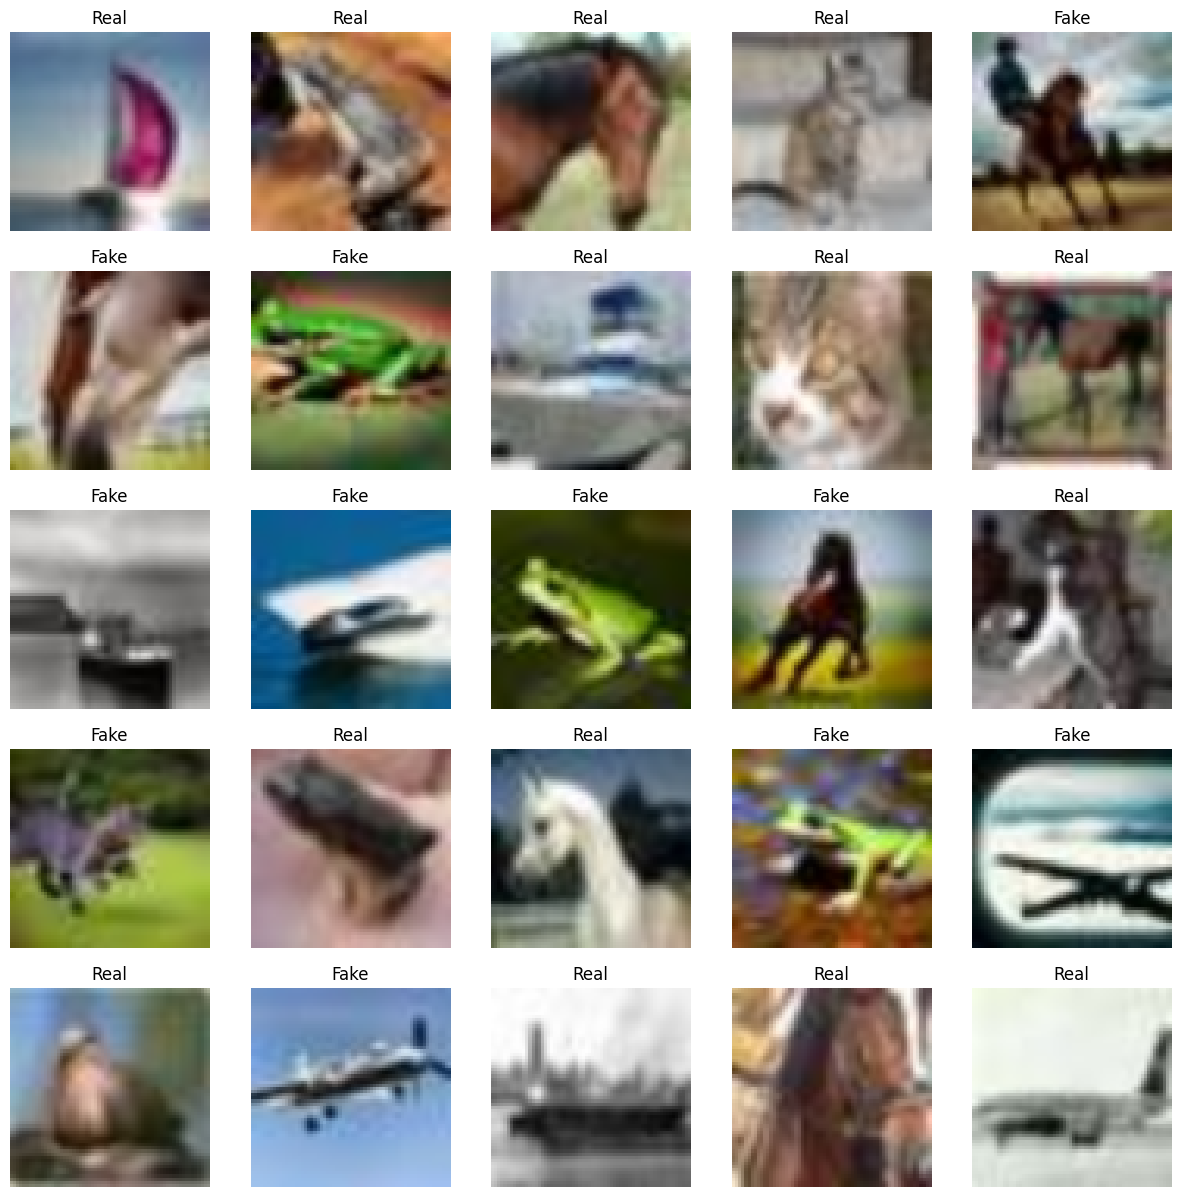

In [4]:
for images,labels in train_data:
    plt.figure(figsize=(15,15))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].permute(1,2,0))
        plt.title(f"{'Real' if labels[i] else 'Fake'}")
        plt.axis('off')
    plt.show()
    break

<sup><sub>

## 🧩 Model Architecture Overview

The classifier uses a lightweight CNN designed for efficient training on 64×64 images.

### **Feature Extractor**
- 3 convolution blocks  
- Each block: Conv2d → BatchNorm2d → ReLU → MaxPool2d  
- Channel progression: 32 → 64 → 128  
- Output feature map: (128, 8, 8)  

This structure balances speed and accuracy, reducing computation while retaining key visual patterns.

### **Fully Connected Head**
- Flatten → Linear(8192 → 512) → BN → ReLU → Dropout  
- Linear(512 → 128) → BN → ReLU → Dropout  
- Linear(128 → 32) → BN → ReLU → Dropout  
- Linear(32 → 1)  

Outputs a single logit for binary classification using BCEWithLogitsLoss.

### **Why This Architecture?**
- Small enough to train quickly on Kaggle GPUs  
- Deep enough to capture texture differences between real and synthetic images  
- BatchNorm stabilizes training  
- Dropout improves generalization  

</sub></sup>

In [5]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.features=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2,stride=2),

            torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2,stride=2),

            torch.nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.dense=torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128*8*8,512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(512,128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(128,32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(32,1),
            # torch.nn.Sigmoid()
        )

    def forward(self,x):
        features=self.features(x)
        logits=self.dense(features)
        return logits
        

<sup><sub>

## 🏋️ Training Loop Summary

The training pipeline is optimized for speed, clarity, and reproducibility.

### **Core Features**
- Non-blocking GPU transfers  
- AMP mixed precision (autocast + GradScaler)  
- Adam optimizer  
- BCEWithLogitsLoss for binary classification  
- Per-epoch validation  

### **Training Steps**
1. Move batch to GPU using non-blocking memory transfer  
2. Run forward pass inside autocast for FP16 efficiency  
3. Compute loss  
4. Backpropagate using GradScaler for stability  
5. Update model parameters  
6. Track accuracy from logits using `pred > 0`  

### **Validation Phase**
- No gradient calculation  
- Autocast enabled for faster inference  
- Metrics tracked separately  

### **Why It’s Efficient**
- Avoids CPU transforms  
- All tensors preloaded into RAM  
- No worker processes needed  
- AMP reduces computation cost significantly  

</sub></sup>

In [6]:
def train(epochs,train_data,validation_data):
    print('Loading Device....')
    device='cuda' if torch.cuda.is_available() else 'cpu'
    if device=='cuda':
        print('External GPU found and availabel to use')
    else:print('External GPU not available ')

    print('='*80)

    model=Classifier().to(device)
    
    if torch.cuda.get_device_properties(0).major >= 7:
        model=torch.compile(model)
        print("Using torch.compile")
    else:
        print("torch.compile disabled: GPU compute capability < 7.0")
    
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
    criterion=torch.nn.BCEWithLogitsLoss()
    
    num_train_batches=len(train_data)
    num_validation_batches=len(validation_data)

    scaler=torch.amp.GradScaler('cuda')
    torch.backends.cudnn.benchmark=True
    
    for epoch in range(epochs):
        total_loss=0
        epoch_correct=0
        epoch_total=0

        
        epoch_start=time.time()
        for images,labels in train_data:
            
            images=images.to(device,non_blocking=True)
            labels=labels.to(device,non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                pred=model(images).flatten()
                loss=criterion(pred,labels.float())
                
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                pred_labels=pred>0
                
                total_loss+=loss.item()
                num_correct_pred=(pred_labels==labels).sum().item()
                total=labels.numel()
                
                epoch_correct+=num_correct_pred
                epoch_total+=total

        average_loss=total_loss/num_train_batches
        epoch_accuracy=epoch_correct/epoch_total


        val_epoch_loss=0
        val_epoch_correct=0
        val_epoch_total=0
        
        with torch.no_grad(),torch.amp.autocast('cuda'):
            for images,labels in validation_data:
                images=images.to(device,non_blocking=True)
                labels=labels.to(device,non_blocking=True)

                pred=model(images).flatten()
                pred_labels=pred>0

                loss=criterion(pred,labels.float())
                val_epoch_loss+=loss.item()
                num_correct_pred=(pred_labels==labels).sum().item()
                total=labels.numel()

                val_epoch_correct+=num_correct_pred
                val_epoch_total+=total


        average_val_loss=val_epoch_loss/num_validation_batches
        val_epoch_accuracy=val_epoch_correct/val_epoch_total

        epoch_time=time.time()-epoch_start

        print(f"Epochs:{epoch+1:<2}/{epochs:<29}Time Taken:{epoch_time:.2f}s")
        print(f'Training Loss:{average_loss:<25}Training Accuracy:{epoch_accuracy}')
        print(f'Validation Loss:{average_val_loss:<23}Validation Accuracy:{val_epoch_accuracy}\n')
        

    print('Training Finished!')
    print('='*80)

<sup><sub>

## 📊 Results & Visualization

After training, we visualize a batch of images with predicted labels.

### **Displayed Outputs**
- 25-sample grid (5×5)  
- True labels: REAL or FAKE  
- Quick inspection of class boundaries  
- Useful for verifying dataset quality  

### **Accuracy Trends**
- Increasing accuracy indicates the model is learning  
- If loss decreases but accuracy stalls, check:  
  - Data imbalance  
  - Incorrect thresholding  
  - Logit interpretation  

### **Model Behavior Notes**
- CNNs perform well at texture detection  
- Fake images often differ in color smoothness, edge artifacts, and fine details  
- Visualizing predictions provides qualitative confirmation  

</sub></sup>

In [7]:
train(20,train_data,validation_data)

Loading Device....
External GPU found and availabel to use
Using torch.compile


W1207 21:29:15.587000 20 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Epochs:1 /20                           Time Taken:72.85s
Training Loss:0.23470855196532997      Training Accuracy:0.90689
Validation Loss:0.19479600378092687    Validation Accuracy:0.9236

Epochs:2 /20                           Time Taken:10.47s
Training Loss:0.1540458101464812       Training Accuracy:0.94176
Validation Loss:0.13768667746691188    Validation Accuracy:0.94575

Epochs:3 /20                           Time Taken:10.36s
Training Loss:0.12387724447985897      Training Accuracy:0.95332
Validation Loss:0.13316211783012766    Validation Accuracy:0.94845

Epochs:4 /20                           Time Taken:10.45s
Training Loss:0.10561060021771952      Training Accuracy:0.95981
Validation Loss:0.13139065452347135    Validation Accuracy:0.95045

Epochs:5 /20                           Time Taken:10.50s
Training Loss:0.0893738616967712       Training Accuracy:0.96661
Validation Loss:0.12889849764716094    Validation Accuracy:0.9531

Epochs:6 /20                           Time Taken:10